# MC based Cosmic Rate studies
This notebook does use the event/pfp/mcp trees, but no data

## Imports

In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import helpfunction as helper
%matplotlib inline

In [2]:
pd.options.display.max_columns=999

In [47]:
main_tree_name = 'cosmicstudies'

# Input files
file_name_mc_sce = './input/corsika_p_sce_30k.root'
file_name_mc_ddsce = './input/corsika_p_ddsce_8k.root'
file_name_mc_nosce = './input/corsika_p_nosce_6k.root'
file_name_mc_cmc = './input/corsika_cmc_sce_8k.root'

outdir = './Output/Paper/'

det_x = np.array([-1.55, 254.8])
det_y = np.array([-115.53, 117.47])
det_z = np.array([0.1, 1036.9])
eps= np.array([-0.001, 0.001])

muon_mass = 0.105658

good_start = -0.4e6          # Start of MC time where we are not biased by out of time charge
good_end = 0.4e6             # End of good MC time window (in ns)
t_begin = good_start/1e6
t_end = good_end/1e6

ub_tag = "MicroBooNE, In Progress"

In [6]:
mc_keys       = ['sce', 'ddsce', 'nosce', 'cmc']
mc_file_names = [file_name_mc_sce, file_name_mc_ddsce, file_name_mc_nosce, file_name_mc_cmc]
mc_files      = [uproot.open(f)[main_tree_name] for f in mc_file_names]
mc_labs       = ['CORSIKA, simulated space charge    ',
                 'CORSIKA, data-driven space charge  ',
                 'CORSIKA, without space charge      ',
                 'CORSIKA+CMC, simulated space charge']

## Load the data

In [14]:
n_events = mc_files[0]['Event'].numentries

In [9]:
# Load mcp df
df_mcp = mc_files[0]['MCParticles'].pandas.df().query('(mc_process==23) & (mc_pdg_code==13 | mc_pdg_code==-13)')

In [11]:
df_mcp['mc_part_inside'].value_counts()

True     948192
False    374280
Name: mc_part_inside, dtype: int64

In [22]:
df_mc_muon_cross = df_mcp.query('mc_part_inside')
df_mc_muon_cross['Kinetic Energy'] = df_mc_muon_cross['mc_energy']-muon_mass

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
# Time in seconds of the sample
total_time = (max(df_mcp['mc_time'])-min(df_mcp['mc_time']))*1e-9*n_events
print(total_time)
# Area in m*m
total_area = (det_x[1]-det_x[0])*(det_z[1]-det_z[0])/1e4

216.0497914


In [51]:
# amount of muons in the TPC:
len(df_mc_muon_cross)/total_time
loc_query = '(mc_startz_tpc>@z_safe[0]) & (mc_startz_tpc< @z_safe[1]) & \
             (mc_startx_tpc>@x_safe[0]) & (mc_startx_tpc< @x_safe[1])'

rate = len(df_mc_muon_cross.query(loc_query)["mc_startz_tpc"])/total_area/total_time
err = np.sqrt(rate*total_area*total_time)/total_area/total_time
print('Muon flux though TPC top: {0:.2f}+-{1:.2f} muons/(m*m*s)'.format(rate,err))
rate_tpc = len(df_mc_muon_cross)/total_time
err = np.sqrt(rate*total_time)/total_time
print('Muon flux in TPC: {0:.1f}+-{1:.1f} muons/s'.format(rate_tpc,err))

Muon flux though TPC top: 111.45+-0.14 muons/(m*m*s)
Muon flux in TPC: 4388.8+-0.7 muons/s


## Plots MC only

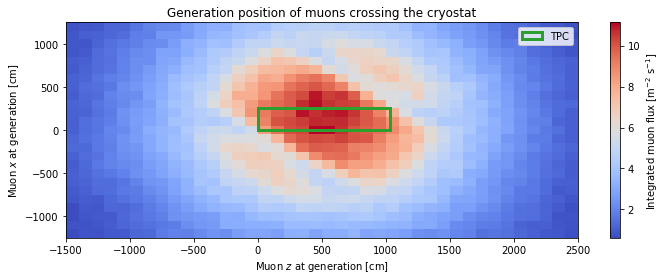

In [40]:
# Make a plot of the muon density at the generation!
# Area in m*m
this_area = (40)*(25)
weights = np.full((len(df_mcp_gen)), (25*40)/this_area/total_time)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
c = ax.hist2d(df_mcp_gen["mc_startz"],df_mcp_gen["mc_startx"], range=((-1500,2500),(-1250,1250)), 
              cmap='coolwarm', bins=(40,25), weights=weights)
clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')
rect = patches.Rectangle((det_z[0],det_x[0]),det_z[1]-det_z[0],det_x[1]-det_x[0],
                         linewidth=3,edgecolor='C2',facecolor='none', label='TPC')
ax.add_patch(rect)
ax.legend()
ax.set_ylabel(r'Muon $x$ at generation [cm]')
ax.set_xlabel(r'Muon $z$ at generation [cm]')
ax.set_title('Generation position of muons crossing the cryostat')

fig.tight_layout()
plt.savefig(outdir+"startxz_generation.pdf", bbox_inches="tight")

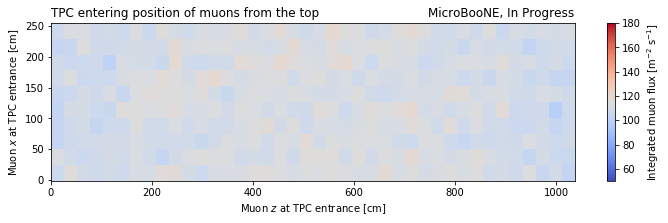

In [48]:
# Make a plot of the muon density at TPC entrance!
fig, ax = plt.subplots(1, 1, figsize=(10, 3.2))

np.full((2, 2), np.inf)

x_bin = 10
z_bin = 40
z_safe = det_z-eps
x_safe = det_x-eps
weights = np.full((len(df_mc_muon_cross["mc_startz_tpc"])), (x_bin*z_bin)/total_area/total_time)

c = ax.hist2d(df_mc_muon_cross["mc_startz_tpc"],df_mc_muon_cross["mc_startx_tpc"], 
              range=((z_safe[0], z_safe[1]), (x_safe[0], x_safe[1])), 
              cmap='coolwarm', bins=(z_bin,x_bin), weights=weights, vmin=50,vmax=180)

clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')

ax.set_ylabel(r'Muon $x$ at TPC entrance [cm]')
ax.set_xlabel(r'Muon $z$ at TPC entrance [cm]')
ax.set_title('TPC entering position of muons from the top', loc='left')
ax.set_title(ub_tag, loc='right')

fig.tight_layout()
plt.savefig(outdir+"startxz_crossing.pdf", bbox_inches="tight")

In [18]:
# What fraction of muons stop inside the TPC?
stopping_fraction = df_mc_muon_cross['mc_end_inside'].value_counts().values[1]/len(df_mc_muon_cross)
print('Fraction of stopping muons: {0:.2f}%'.format(stopping_fraction*100))

Fraction of stopping muons: 11.61%


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


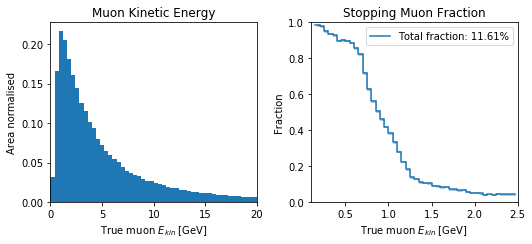

In [28]:
# make a plot of the muon kinetic energy and the fraction of stopping muons in function of that!
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
N=50
edges = np.linspace(0,20,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(df_mc_muon_cross['Kinetic Energy'], bins=edges, density=1)
ax[0].set_xlim(0,20)
ax[0].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[0].set_ylabel('Area normalised')
ax[0].set_title('Muon Kinetic Energy')

N=50
edges = np.linspace(0,2.5,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
denom,_ = np.histogram(df_mc_muon_cross['Kinetic Energy'], bins=edges)
nom,_ = np.histogram(df_mc_muon_cross.query('mc_end_inside')['Kinetic Energy'], bins=edges)
fraq = nom/denom

err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Total fraction: {0:.2f}%'.format(stopping_fraction*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')
ax[1].set_xlim(0.1,2.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Stopping Muon Fraction')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig(outdir+"mc_muon_E.pdf", bbox_inches="tight")

## Plots MC+TPC

In [55]:
# Load pfp df
mc_pfp = [f['PFParticles'].pandas.df() for f in mc_files]
#['sce', 'ddsce', 'nosce', 'cmc']
mc_def = 0

In [58]:
primary_matched_query = '(track_matched_process==23)'
muon_matched_query = '(track_matched_pdgcode==13 | track_matched_pdgcode==-13)'
intpc_matched_query = '(track_matched_length_tpc>0)' 
matched_query = primary_matched_query+' & '+muon_matched_query+ ' & '+intpc_matched_query
df_pfp_matched_unique = mc_pfp[0].drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched = df_pfp_matched_unique.query(matched_query)
df_mc_muon_cross_matched_25 = df_mc_muon_cross_matched.query("track_length>25")

In [65]:
#Fraction of muon track that are in the tpc for 25cm compared to 5cm
print(len(df_mc_muon_cross.query("mc_length_tpc>5"))/len(df_mc_muon_cross.query("mc_length_tpc>0")))
print(len(df_mc_muon_cross.query("mc_length_tpc>25"))/len(df_mc_muon_cross.query("mc_length_tpc>0")))

0.9864616027133745
0.9322320795788195


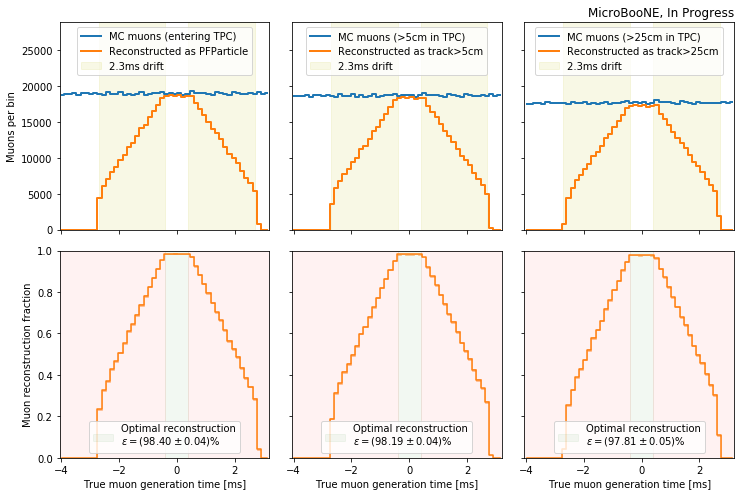

In [66]:
fig, ax = plt.subplots(ncols = 3, nrows=2, sharey='row', sharex=True, figsize=(10.5,7))
N=50
x_min=min(df_mc_muon_cross['mc_time']/1e6)
x_max=max(df_mc_muon_cross['mc_time']/1e6)

nom_labs  =['Reconstructed as PFParticle', 'Reconstructed as track>5cm', 'Reconstructed as track>25cm']
denom_arr   = [df_mc_muon_cross['mc_time']/1e6, 
             df_mc_muon_cross.query("mc_length_tpc>5")['mc_time']/1e6, 
             df_mc_muon_cross.query("mc_length_tpc>25")['mc_time']/1e6]

denom_labs = ['MC muons (entering TPC)', 'MC muons (>5cm in TPC)', 'MC muons (>25cm in TPC)']
nom_arr =[df_mc_muon_cross.query("mc_is_matched==1")['mc_time']/1e6, 
            df_mc_muon_cross_matched.query('track_matched_length_tpc>5')['track_matched_time']/1e6,
            df_mc_muon_cross_matched_25.query('track_matched_length_tpc>25')['track_matched_time']/1e6]

edges, edges_mid, nom_bins, nom_errs, max_y = helper.histHelper(N, x_min, x_max, nom_arr)
_, _, denom_bins, denom_errs, max_y = helper.histHelper(N, x_min, x_max, denom_arr)

iterable = enumerate(zip(nom_arr, nom_labs,nom_bins, nom_errs, denom_arr, denom_labs, denom_bins, denom_errs))
for i,(nom, nom_lab,nom_bin, nom_err, denom, denom_lab, denom_bin, denom_err) in iterable:
    # Upper row
    ax[0][i].step(edges_mid, denom_bin, lw=2, label=denom_lab, where='mid')
    ax[0][i].fill_between(edges_mid, denom_bin - denom_err, denom_bin - denom_err, alpha=0.3, step='mid') 
    ax[0][i].step(edges_mid, nom_bin, lw=2, label=nom_lab, where='mid')
    ax[0][i].fill_between(edges_mid, nom_bin - nom_err, nom_bin - nom_err, alpha=0.3, step='mid')
    ax[0][i].set_ylim(0,max(max_y)*1.5)
    ax[0][i].set_xlim(x_min,x_max)
    ax[0][i].axvspan(t_begin-2.3,t_begin, alpha=0.1, color="y", label='2.3ms drift')
    ax[0][i].axvspan(t_end,t_end+2.3, alpha=0.1, color="y")
    ax[0][i].legend(loc='upper center')
    
    # Lower row
    ratio = sum(nom.between(t_begin,t_end))/sum(denom.between(t_begin,t_end))
    ratio_err = np.sqrt((1-ratio)*ratio/sum(denom.between(t_begin,t_end)))
    fraq = nom_bin/denom_bin
    err = np.sqrt( fraq*(1-fraq)/denom_bin )
    ax[1][i].step(edges_mid, fraq, where='mid',color="C1")
    ax[1][i].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')
    ax[1][i].set_ylim(0,1)
    ax[1][i].axvspan(x_min,t_begin, alpha=0.05, color="red")
    ratio_str = r'$\varepsilon = ({0:.2f}\pm{1:.2f})\%$'.format(ratio*100,ratio_err*100)
    ax[1][i].axvspan(t_begin,t_end, alpha=0.05, color="green", label='Optimal reconstruction\n'+ratio_str)
    ax[1][i].axvspan(t_end,x_max, alpha=0.05, color="red")
    ax[1][i].set_xlabel(r'True muon generation time [ms]')
    ax[1][i].legend(loc='lower center')
    
ax[0][0].set_ylabel(r'Muons per bin')
ax[1][0].set_ylabel(r'Muon reconstruction fraction')
ax[0][2].set_title(ub_tag, loc='right')

fig.tight_layout()
fig.savefig(outdir+"match_eff.pdf", bbox_inches="tight")

## Plots MC+PMTS